<6회차 학습 내용>
- 다양한 분류 알고리즘 활용
- 보험 가입 분류 연습
- 인공신경망 개요 및 이해
- 신용카드 부정사용 탐지 연습

Data  
- scaling
- partitioning
- column
- Encoding

지도학습  
 - 회귀
 - 분류 
   - Tree: Dt ... 변화 -> ensenble(bagging, boosting))
     - Tree는 성능 안좋음, 단순하고 비모수적이다.
     - 성능 개선한게 앙상블 모형 xgb lgb등
   - 거리기반: knn, svm
     - 더 단순하다. 눈으로 보기 좋음
   - 선형: logistic

#1. 다양한 분류 알고리즘의 활용

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Loading iris dataset from sklearn
iris = load_iris()

#independent feautres
X = iris.data

# target features
y = iris.target

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

y = diabetes.Outcome
X = diabetes.drop("Outcome", axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000
...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333


In [ ]:
#다양한 분류모형 비교
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
MLA = [
    #Tree, Ensemble Methods
    tree.DecisionTreeClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Nearest Neighbor
    KNeighborsClassifier()]


In [ ]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

#train_test_split보다 편하게 여러개 생성 가능 (10개를 만들거임 60:30으로 10은 뺴두기)
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#MLA 비교 (MLA Test Accuracy 3*STD = 표준편차*3)
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(y)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #CV score: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)
    row_index+=1
 

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
7,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.974444,0.968889,0.044222,0.000856
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.984444,0.964444,0.08,0.755509
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.957778,0.081377,0.001626
1,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",1.0,0.957778,0.086667,0.116409
4,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",1.0,0.957778,0.081377,0.267884
5,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.955556,0.084327,0.148624
2,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",1.0,0.948889,0.111754,0.030607
3,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.965556,0.948889,0.111754,0.079658


Text(0, 0.5, 'Algorithm')

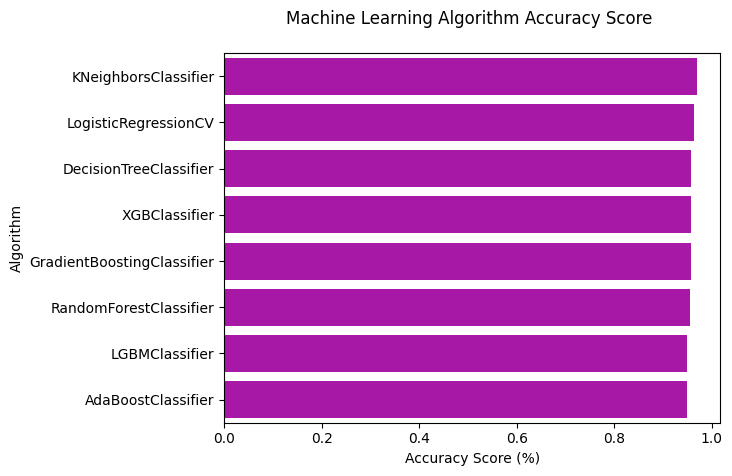

In [ ]:
#barplot
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

- 위의 방법을 diabetes.csv에 적용해보세요.

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

y = diabetes.Outcome
X = diabetes.drop("Outcome", axis=1)

#불러와서 스케일링, 나머진 동일
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#다양한 분류모형 비교
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

MLA = [
    #Tree, Ensemble Methods
    tree.DecisionTreeClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Nearest Neighbor
    KNeighborsClassifier()]

#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

#train_test_split보다 편하게 여러개 생성 가능 (10개를 만들거임 60:30으로 10은 뺴두기)
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#MLA 비교 (MLA Test Accuracy 3*STD = 표준편차*3)
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(y)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #CV score: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)
    row_index+=1
 

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
5,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.771861,0.053563,0.252505
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.773913,0.769697,0.077226,0.466167
4,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.947391,0.760173,0.058427,0.198249
2,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999783,0.751515,0.069502,0.042367
3,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.852826,0.751082,0.055784,0.104957
1,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",1.0,0.748052,0.067931,0.077121
7,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.800435,0.734199,0.048314,0.003022
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.719481,0.077008,0.0043


#2. 보험 가입 연습문제
 - https://www.kaggle.com/c/prudential-life-insurance-assessment
 -  가입상품, 나이, BMI, 보험이력, 고용정보 등 Prudential 보험사의 데이터를 기반으로 고객들을 위험군에 따라서 1~8등급으로 분류

In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

unzip:  cannot find or open train.csv.zip, train.csv.zip.zip or train.csv.zip.ZIP.
unzip:  cannot find or open test.csv.zip, test.csv.zip.zip or test.csv.zip.ZIP.


In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv("train.csv")
train, test = train_test_split( data, test_size=0.3, shuffle=True, stratify = data.Response)


In [ ]:
train.shape

(41566, 128)

In [ ]:
train.head()
train.isnull().mean()
test.isnull().mean()
train.Response.unique()
print(train.Response.value_counts()/41566*100)
print(test.Response.value_counts()/17815*100)

8    32.820093
6    18.916903
7    13.518260
2    11.033056
1    10.453255
5     9.146899
4     2.405812
3     1.705721
Name: Response, dtype: float64
8    32.820657
6    18.916643
7    13.516699
2    11.035644
1    10.451866
5     9.149593
4     2.402470
3     1.706427
Name: Response, dtype: float64


In [ ]:
#OHE (sklearn OneHotEncoder, pd.get_dummies, to_categories....)
y_train = pd.get_dummies( train["Response"] )
y_test = pd.get_dummies( test["Response"] )

#인코딩, 라벨링
y_train.head()

,1,2,3,4,5,6,7,8
59359,0,0,0,0,0,1,0,0
43540,0,0,0,0,0,0,1,0
58481,0,0,0,0,0,0,1,0
45178,0,0,0,0,0,1,0,0
29486,0,0,0,0,0,1,0,0


In [ ]:
train.drop( ["Id", "Response"], axis=1, inplace=True)
test.drop(["Id", "Response"], axis=1, inplace=True)

In [ ]:
#Transform categorical values to dummies 0/1
#print( [i for i in train.columns if train[i].dtype=="O"] )
categorical = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_10', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41','Medical_History_1', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']
numeric = [ i for i in train.columns if i not in categorical ]
train_num = train[ numeric ]
test_num = test[ numeric ]

from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan).fit(train[categorical])
train_enc = pd.DataFrame( oe.transform(train[categorical]), index=train.index) # index=train.index를 하지않으면 인덱스가 달라짐
test_enc = pd.DataFrame( oe.transform(test[categorical]), index=test.index )


In [ ]:
train_new =  pd.concat( [ train_num, train_enc], axis=1)
test_new =  pd.concat( [ test_num, test_enc], axis=1)
train_new.columns

Index([     'Product_Info_4',             'Ins_Age',                  'Ht',
                        'Wt',                 'BMI',   'Employment_Info_1',
         'Employment_Info_4',   'Employment_Info_6', 'Insurance_History_5',
             'Family_Hist_2',
       ...
                          55,                    56,                    57,
                          58,                    59,                    60,
                          61,                    62,                    63,
                          64],
      dtype='object', length=126)

In [ ]:
xgb = XGBClassifier(n_estimators=20, max_depth=5, learning_rate=0.01, verbosity=3).fit( train_new, y_train)

# keyworded argument 표현식
#param = {n_estimators:20, max_depth:5, learning_rate:0.01, verbosity:3}
#xgb = XGBClassifier(**param).fit( train_new, y_train)

[00:50:27] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:50:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:50:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:50:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[00:50:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[00:50:28] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:50:28] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:50:28] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[00:50:28] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:50:28] INFO: ../src/tree/updater_pr

In [ ]:
xgb.score(test_new, y_test)

0.3888296379455515

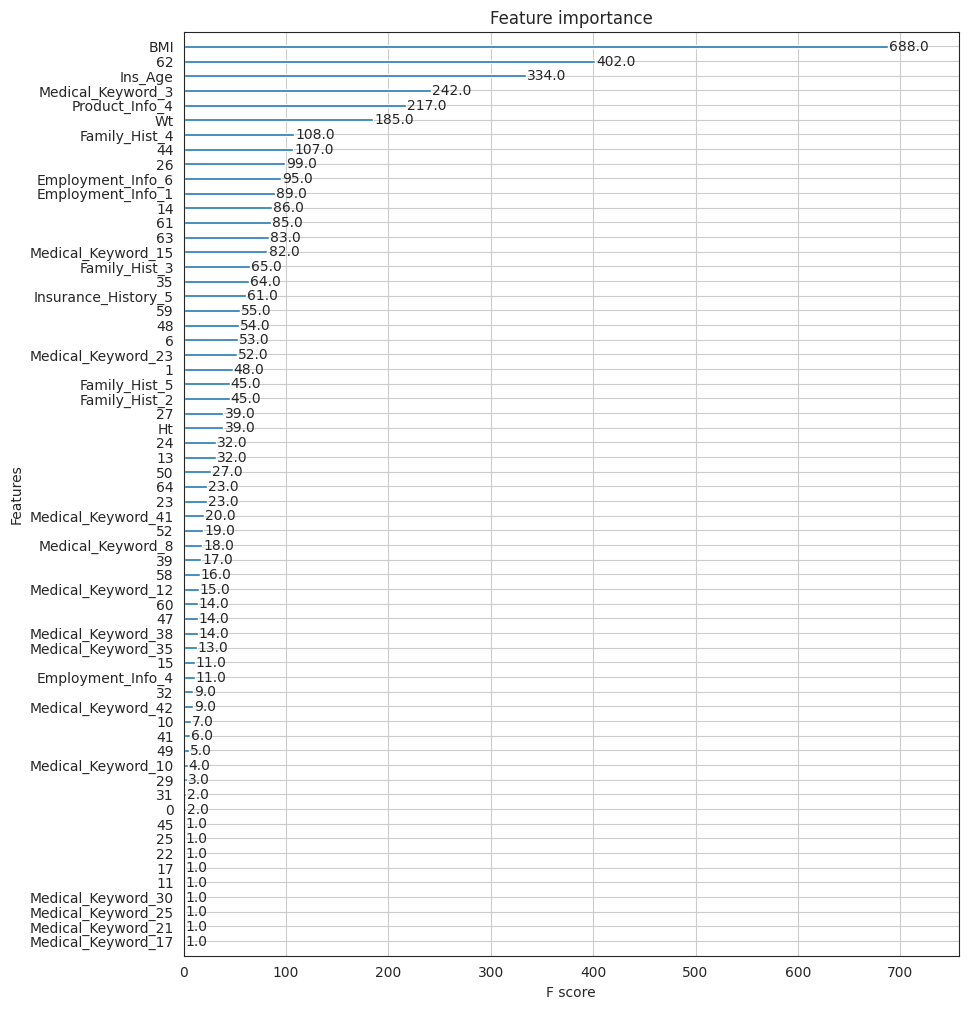

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred= xgb.predict(test_new)
print( classification_report( y_test, pred ) )

              precision    recall  f1-score   support

           0       0.58      0.05      0.08      1862
           1       0.61      0.12      0.20      1966
           2       0.62      0.34      0.43       304
           3       0.60      0.62      0.61       428
           4       0.63      0.40      0.49      1630
           5       0.61      0.28      0.38      3370
           6       0.00      0.00      0.00      2408
           7       0.68      0.81      0.74      5847

   micro avg       0.66      0.39      0.49     17815
   macro avg       0.54      0.33      0.37     17815
weighted avg       0.55      0.39      0.41     17815
 samples avg       0.39      0.39      0.39     17815



In [ ]:
np.argmax( pred, axis=1)

array([7, 0, 0, ..., 7, 0, 7])

- LightGBM
 - 기존의 boosting 모델들은 트리를 level-wise하게 늘어나는 방법을 사용하였음. Lightgbm은 leaf wise(리프 중심) 트리 분할을 사용.

<figure>
    <img src='
https://blog.kakaocdn.net/dn/r82C1/btqzT495GKp/cJekkdIkbGNfennTj7DyQk/img.jpg' width=700 height=300>
</figure>


 - 기존의 트리 깊이(tree depth)를 줄이는 level wise(균형 트리) 분할 대신 Leaf wise 방식
  - lightgbm은 트리의 균형 대신 리프 노드를 지속적으로 분할

 - 비대칭적이고 깊은 트리가 생성되지만 동일한 leaf를 생성할때 leaf-wise는 level-wise보다 손실을 줄일 수 있는 장점


- 파라미터 소개

 - n_estimators : 반복하려는 트리의 개수

 - learning_rate : 학습률

 - max_depth : 트리의 학습개수

 - min_child_samples : 리프 노드가 되기 위한 최소한의 샘플 데이터 수

 - num_leaves :  하나의 트리가 가질 수 있는 최대 리프 개수

 - feature_fraction : 트리를 학습할 때마다 선택하는 feature의 비율

 - reg_lambda : L2 regularization, reg_alpga : L1 regularization

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


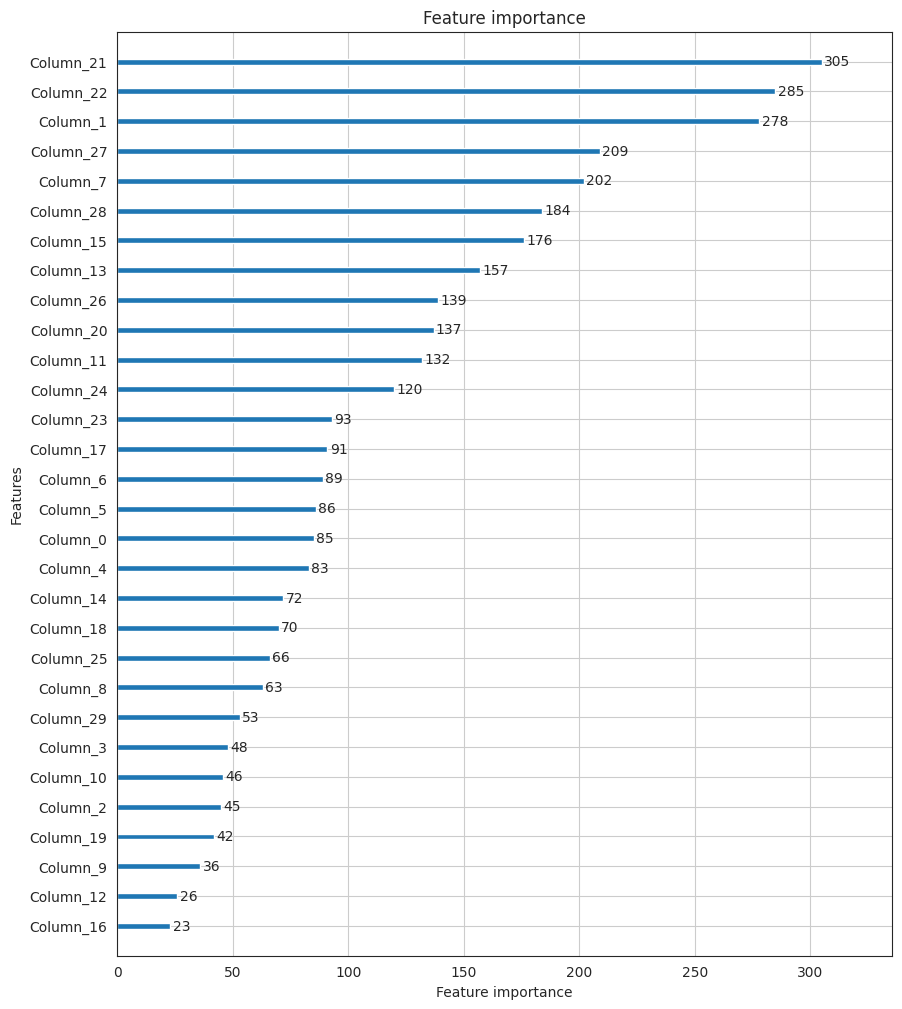

In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from lightgbm import plot_importance
import matplotlib.pyplot as plt

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target


X_trn, X_tst, y_trn, y_tst = train_test_split(ftr, target, test_size=0.2, random_state=156)
lgbm_wrapper = LGBMClassifier(n_estimators=400)
evals = [(X_tst, y_tst)]
lgbm_wrapper.fit(X_trn, y_trn,verbose=True)
pred = lgbm_wrapper.predict(X_tst)
pred_proba = lgbm_wrapper.predict_proba(X_tst)[:1]

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

In [ ]:
y_train_inv = np.argmax(y_train.values, axis=1)
y_test_inv = np.argmax(y_test.values, axis=1)

In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import plot_importance
import matplotlib.pyplot as plt

lgbm_wrapper = LGBMClassifier(n_estimators=400).fit(train_new, y_train_inv ,verbose=True)
pred = lgbm_wrapper.predict(test_new)
pred_proba = lgbm_wrapper.predict_proba(test_new)[:1]

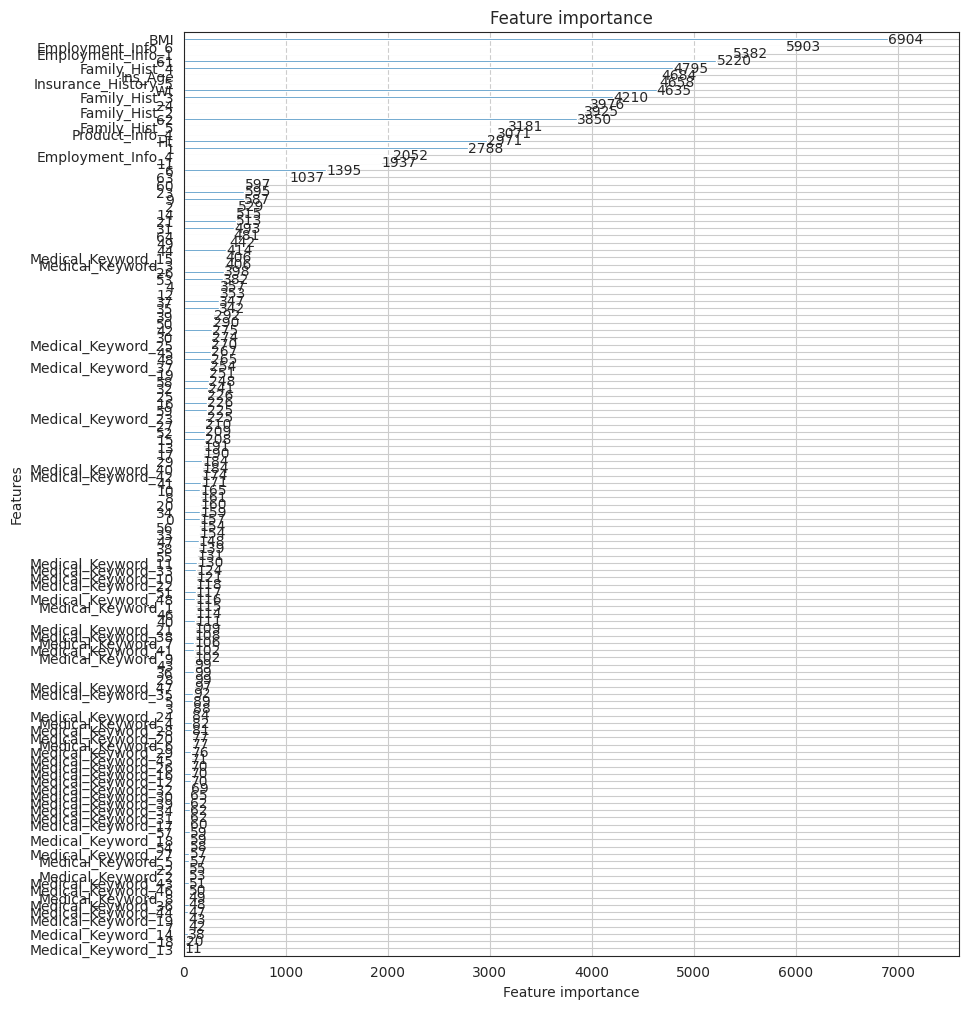

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

In [ ]:
print( lgbm_wrapper.score(test_new, y_test_inv) )
print( classification_report( y_test_inv, pred ))

0.5840583777715408
              precision    recall  f1-score   support

           0       0.44      0.28      0.34      1862
           1       0.41      0.25      0.31      1966
           2       0.53      0.35      0.42       304
           3       0.63      0.62      0.63       428
           4       0.63      0.53      0.57      1630
           5       0.51      0.53      0.52      3370
           6       0.47      0.46      0.47      2408
           7       0.69      0.90      0.78      5847

    accuracy                           0.58     17815
   macro avg       0.54      0.49      0.51     17815
weighted avg       0.56      0.58      0.56     17815



 - Optuna : 하이퍼파라미터 최적화 


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
# import the other libraries
import optuna # for hyper parameter tuning
from xgboost import XGBClassifier as cls

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn import datasets
from sklearn.metrics import make_scorer, accuracy_score

from functools import partial

In [ ]:
def objective(X, y, trial):
    params = {
        'booster':trial.suggest_categorical('booster', ['gbtree', 'dart', 'gblinear']),
        'learning_rate':trial.suggest_uniform("learning_rate", 0.01, 0.02),
        'max_depth':trial.suggest_int("max_depth", 2, 4)
            }

    model = cls(**params)
    score = cross_val_score(model, X, y, cv=2, scoring=make_scorer(accuracy_score))

    return 1 - score.mean()

In [ ]:
f = partial(objective, train_new, y_train_inv)

study = optuna.create_study()
study.optimize(f, n_trials=2)

[I 2023-05-21 23:15:33,217] A new study created in memory with name: no-name-61f5b17e-a858-42dc-9239-108662c0e334
<ipython-input-29-b2413e3d5aee>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_uniform("learning_rate", 0.01, 0.02),
[I 2023-05-21 23:16:37,933] Trial 0 finished with value: 0.4756291199538084 and parameters: {'booster': 'gbtree', 'learning_rate': 0.015603537785136533, 'max_depth': 2}. Best is trial 0 with value: 0.4756291199538084.
<ipython-input-29-b2413e3d5aee>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_uniform("learning_rate", 0.01, 0.02),


[23:16:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[23:16:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.



[I 2023-05-21 23:17:10,926] Trial 1 finished with value: 0.5776355675311553 and parameters: {'booster': 'gblinear', 'learning_rate': 0.01860983504418395, 'max_depth': 4}. Best is trial 0 with value: 0.4756291199538084.


In [ ]:
# evaluate the model
model = cls(**study.best_params)
model.fit(train_new, y_train_inv)
y_true = y_test
y_pred = model.predict(test_new)


In [ ]:
print(classification_report( y_test_inv, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.04      0.07      1862
           1       0.41      0.22      0.28      1966
           2       0.53      0.30      0.38       304
           3       0.51      0.77      0.61       428
           4       0.50      0.56      0.53      1630
           5       0.39      0.40      0.40      3370
           6       0.45      0.20      0.28      2408
           7       0.59      0.95      0.73      5847

    accuracy                           0.52     17815
   macro avg       0.49      0.43      0.41     17815
weighted avg       0.50      0.52      0.46     17815



#3. 불량 발생 예측


- pm_train.csv와 pm_test.csv는 항공기 엔진에 대한 예측정비와 관련된 데이터
- 두 데이터를 읽고, ttf 컬럼이 30일 이하인 경우, 정비 대상이라 고려하여 1을, 그렇지 않은 경우 0 값을 갖는 label 컬럼을 새로 만들어서 추가

- setting1-setting3, 그리고 s1-s21 변수를 X 변수로 하고, label 변수를 target으로 하여, 분류모형을 이용해서 피팅

- 피팅된 모형에 test셋을 넣어 예측하고, 예측 결과는 sklearn의 classification_report를 통해 해석

In [ ]:
import pandas as pd

df_train = pd.read_csv("pm_train.csv")
df_test = pd.read_csv("pm_test.csv")

period=30
df_train['label'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()


,Unnamed: 0,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label
0,0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [ ]:
df_train.isnull().mean()
df_train.label.value_counts()

0    17531
1     3100
Name: label, dtype: int64

In [ ]:
# tree 계열의 모형, ann 모형, 앙상블 모형 1개씩 만들어서 비교.
from sklearn.metrics import classification_report

y = df_train.label
x = df_train.drop("label", axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_train.iloc[:, 3:27])
x_test = scaler.fit_transform(df_test.iloc[:, 3:27])
y_train = pd.get_dummies(df_train.label)
y_test = pd.get_dummies(df_test.label)

from imblearn.over_sampling import SMOTE
y_train = y_train.astype('int')
x_bal, y_bal = SMOTE().fit_resample(x_train, y_train.values)
x_bal = pd.DataFrame(x_bal, columns= df_train.iloc[:, 3:27].columns)

In [ ]:
#트리
from lightgbm import LGBMClassifier
lgbModel = LGBMClassifier().fit(x_train, y_train)
lgb_pred = lgbModel.predict(x_test)
print(classification_report(y_test, lgb_pred))

#ann
from sklearn.neural_network import MLPClassifier
annModel = MLPClassifier().fit(x_train, y_train)
ann_pred = annModel.predict(x_test)
print(classification_report(y_test, ann_pred))

#앙상블
from sklearn.ensemble import GradientBoostingClassifier 
gbModel = GradientBoostingClassifier().fit(x_train, y_train)
gb_pred = gbModel.predict(x_test)
print(classification_report(y_test, gb_pred))

In [ ]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform( df_train.iloc[ :, 3:27])
X_test = scaler.fit_transform( df_test.iloc[ :, 3:27])
y_train = pd.get_dummies( df_train.label )
y_test = pd.get_dummies( df_test.label )

In [ ]:
y_train

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
20626,0,1
20627,0,1
20628,0,1
20629,0,1


In [ ]:
from imblearn.over_sampling import SMOTE

y_train = y_train.astype('int')
X_balance, y_balance = SMOTE().fit_resample(X_train, y_train.values)
X_balance = pd.DataFrame(X_balance, columns = df_train.iloc[ :, 3:27].columns)

In [ ]:
import matplotlib.pyplot as plt 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy Score is 0.74351
      0     1
0  9405  3359
1     0   332
[[0.73683798 0.26316202]
 [0.         1.        ]]


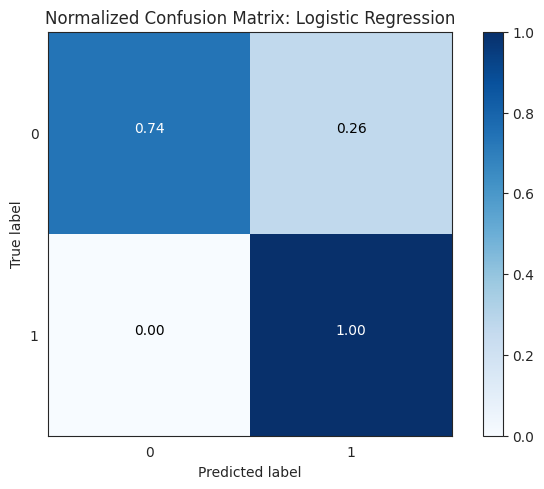

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_balance, y_balance)
y_predict = model.predict(X_test)
y_test_orig = np.argmax( y_test.values, axis=-1)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_orig, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_orig,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_orig,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')


In [ ]:
LR_score = accuracy_score(y_test_orig, y_predict)
LR_percent = LR_score*100
print(f'The model accuracy is {LR_percent}%.')

The model accuracy is 74.35094685400122%.


In [ ]:
#분류 보고서
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
print('\n', classification_report(y_test_orig, y_predict))


               precision    recall  f1-score   support

           0       1.00      0.74      0.85     12764
           1       0.09      1.00      0.17       332

    accuracy                           0.74     13096
   macro avg       0.54      0.87      0.51     13096
weighted avg       0.98      0.74      0.83     13096



## Decision Tree

Accuracy Score is 0.78688
       0     1
0  10003  2761
1     30   302
[[0.7836885  0.2163115 ]
 [0.09036145 0.90963855]]


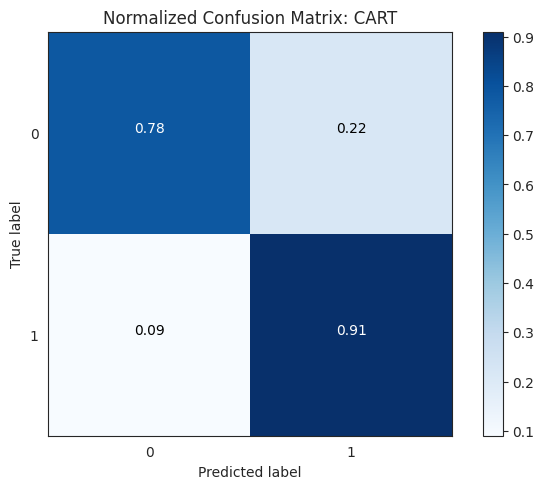

In [ ]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = np.argmax(model.predict(X_test), axis=-1)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_orig, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_orig,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test_orig,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

In [ ]:
DT_score = accuracy_score(y_test_orig, y_predict)
DT_percent = DT_score*100
print(f'The model accuracy is {DT_percent}%.')

The model accuracy is 78.68814905314599%.


In [ ]:
print('\n', classification_report(y_test_orig, y_predict))


               precision    recall  f1-score   support

           0       1.00      0.78      0.88     12764
           1       0.10      0.91      0.18       332

    accuracy                           0.79     13096
   macro avg       0.55      0.85      0.53     13096
weighted avg       0.97      0.79      0.86     13096



## Random Forest   

Accuracy Score is 0.93219
       0    1
0  11891  873
1     15  317
[[0.93160451 0.06839549]
 [0.04518072 0.95481928]]


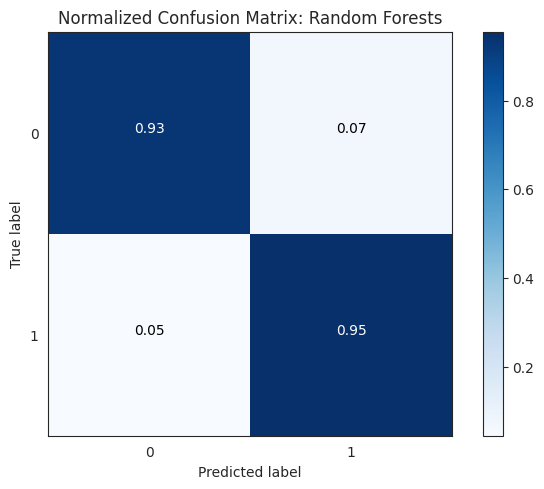

In [ ]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )

model.fit(X_train, y_train)


y_predict = np.argmax(model.predict(X_test), axis=-1)


print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_orig, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_orig,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test_orig,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Random Forests')

In [ ]:
RF_score = accuracy_score(y_test_orig, y_predict)
RF_percent = RF_score*100
print(f'The model accuracy is {RF_percent}%.')

The model accuracy is 93.21930360415394%.


In [ ]:
print('\n', classification_report(y_test_orig, y_predict))


               precision    recall  f1-score   support

           0       1.00      0.93      0.96     12764
           1       0.27      0.95      0.42       332

    accuracy                           0.93     13096
   macro avg       0.63      0.94      0.69     13096
weighted avg       0.98      0.93      0.95     13096



## SVM



Accuracy Score is 0.86897
       0     1
0  11049  1715
1      1   331
[[0.86563773 0.13436227]
 [0.00301205 0.99698795]]


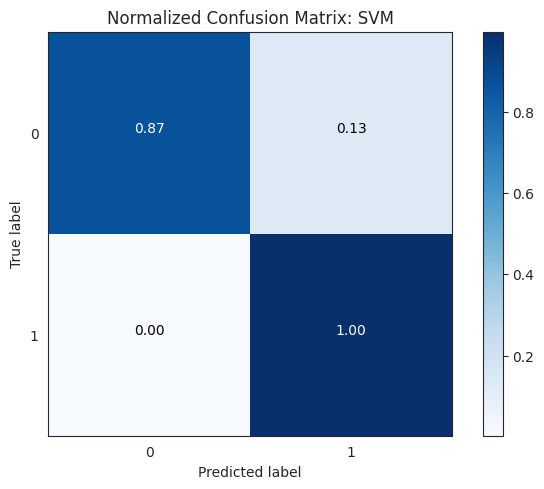

In [ ]:
y_train_orig = np.argmax( y_train.values, axis=-1)
model = svm.SVC(C = 0.8)
model.fit(X_train, y_train_orig)
y_predict =model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_orig, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_orig,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test_orig,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')

In [ ]:
SVM_score = accuracy_score(y_test_orig, y_predict)
SVM_percent = SVM_score*100
print(f'The model accuracy is {SVM_percent}%.')

The model accuracy is 86.89676237018938%.


In [ ]:
print('\n', classification_report(y_test_orig, y_predict))


               precision    recall  f1-score   support

           0       1.00      0.87      0.93     12764
           1       0.16      1.00      0.28       332

    accuracy                           0.87     13096
   macro avg       0.58      0.93      0.60     13096
weighted avg       0.98      0.87      0.91     13096



- GridSearchCV

In [ ]:
from sklearn import model_selection
#defining a set of values as a dictionary for hyperparameters

param_grid = {
    "kernel":['linear', 'rbf'],
    "gamma":[0.01,1],
    "C":[0.1,1]    
}

#declaring GridSearchCV model
model = model_selection.GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    verbose = 10,
    n_jobs = 1,
    cv = 3    
)

#model = model_selection.RandomizedSearchCV(
#    estimator = model,
#    param_distributions = param_grid,
#    scoring = 'accuracy',
#    verbose = 10,
#    n_jobs = 1,
#    cv = 5,
#    n_iter=10
#)

#fitting values to the gridsearchcv model
model.fit(X_train,y_train_orig)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START C=0.1, gamma=0.01, kernel=linear............................
[CV 1/3; 1/8] END C=0.1, gamma=0.01, kernel=linear;, score=0.963 total time=   1.4s
[CV 2/3; 1/8] START C=0.1, gamma=0.01, kernel=linear............................
[CV 2/3; 1/8] END C=0.1, gamma=0.01, kernel=linear;, score=0.957 total time=   1.3s
[CV 3/3; 1/8] START C=0.1, gamma=0.01, kernel=linear............................
[CV 3/3; 1/8] END C=0.1, gamma=0.01, kernel=linear;, score=0.955 total time=   1.3s
[CV 1/3; 2/8] START C=0.1, gamma=0.01, kernel=rbf...............................
[CV 1/3; 2/8] END C=0.1, gamma=0.01, kernel=rbf;, score=0.909 total time=   6.8s
[CV 2/3; 2/8] START C=0.1, gamma=0.01, kernel=rbf...............................
[CV 2/3; 2/8] END C=0.1, gamma=0.01, kernel=rbf;, score=0.910 total time=   5.3s
[CV 3/3; 2/8] START C=0.1, gamma=0.01, kernel=rbf...............................
[CV 3/3; 2/8] END C=0.1, gamma=0.01, ker

GridSearchCV(cv=3, estimator=SVC(C=0.8), n_jobs=1,
             param_grid={'C': [0.1, 1], 'gamma': [0.01, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=10)

In [ ]:
#printing the best possible values to enhance accuracy
print(model.best_params_)
print(model.best_estimator_)
#printing the best score
print(model.best_score_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)
0.9607386941980515


- optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
import sklearn

def objective(trial):
    svc_c = trial.suggest_float("C", 0.9, 1.1, log=True)
    svc_gamma = trial.suggest_float("gamma", 0.9, 1.1, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma=svc_gamma)
    score = sklearn.model_selection.cross_val_score(classifier_obj,
                                                    X_train, y_train_orig, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)




[I 2023-05-21 23:19:36,354] A new study created in memory with name: no-name-0e7ae33e-5f56-489c-a19e-c1d4e9d6844f
[I 2023-05-21 23:19:42,973] Trial 0 finished with value: 0.9608841064417625 and parameters: {'C': 0.9896496857887496, 'gamma': 0.971626075990417}. Best is trial 0 with value: 0.9608841064417625.
[I 2023-05-21 23:19:49,763] Trial 1 finished with value: 0.9607871649459551 and parameters: {'C': 0.9361963681954059, 'gamma': 1.0593928087274604}. Best is trial 0 with value: 0.9608841064417625.
[I 2023-05-21 23:19:54,824] Trial 2 finished with value: 0.9606902234501479 and parameters: {'C': 1.0859428322006095, 'gamma': 0.9797013793480709}. Best is trial 0 with value: 0.9608841064417625.
[I 2023-05-21 23:20:01,558] Trial 3 finished with value: 0.9606417527022443 and parameters: {'C': 1.043782259401186, 'gamma': 1.0351573313326672}. Best is trial 0 with value: 0.9608841064417625.
[I 2023-05-21 23:20:06,758] Trial 4 finished with value: 0.9606902234501478 and parameters: {'C': 0.9746

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.9608841064417625
  Params: 
    C: 0.9896496857887496
    gamma: 0.971626075990417


- ann

In [ ]:
from sklearn.datasets import load_iris
data = load_iris()

X = data.data
y = data.target

from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(X, y)
model.score(X, y)
model.get_params()

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100,50), activation="relu", learning_rate_init=0.001, max_iter=200).fit(X, y)
model.score(X, y)
model.coefs_
pred = model.predict(X)

from sklearn.metrics import classification_report
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.94      0.97        50
           2       0.94      1.00      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(12,6,3)).fit(X_train, y_train)
results = model.predict( X_test)

In [ ]:
#분류 보고서
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
print('\n', classification_report(np.argmax(y_test.values, axis = -1), np.argmax(results, axis = -1)))


               precision    recall  f1-score   support

           0       1.00      0.83      0.91     12764
           1       0.13      1.00      0.23       332

    accuracy                           0.83     13096
   macro avg       0.57      0.91      0.57     13096
weighted avg       0.98      0.83      0.89     13096



In [ ]:
#sms.csv를 읽어서 스팸모형필터 만들기 타겟변수: type
# 파티셔닝 스케일링 ann report

import pandas as pd

sms = pd.read_csv("sms.csv")

y = sms["type"]
X = sms.drop("type", axis=1)

from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(x_train, y_train)
print(model.score(x_test, y_test))

pred = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

0.9426008968609866
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.83      0.69      0.76       143

    accuracy                           0.94      1115
   macro avg       0.89      0.84      0.86      1115
weighted avg       0.94      0.94      0.94      1115



In [ ]:
# 은닉층 구조를 변경
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,50), activation="relu", learning_rate_init=0.001, max_iter=200).fit(x_train, y_train)
print(model.score(x_test, y_test))

pred = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

# lgbm이랑 비교하기
from lightgbm import LGBMClassifier
lgbModel = LGBMClassifier()
lgbModel.fit(x_train, y_train)
lgb_pred = lgbModel.predict(x_test)
print(classification_report(y_test, pred))

0.9443946188340807
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.88      0.66      0.75       143

    accuracy                           0.94      1115
   macro avg       0.91      0.82      0.86      1115
weighted avg       0.94      0.94      0.94      1115

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.88      0.66      0.75       143

    accuracy                           0.94      1115
   macro avg       0.91      0.82      0.86      1115
weighted avg       0.94      0.94      0.94      1115



In [ ]:
# 3.5 분류모형 적용하기
# x는 2차원으로 변경
# y는 10개의 범주
# 스케일링, ohe등 기법 적용
# 원하는 모델로 적용

from tensorflow import keras
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.reshape(-1, 32*32*3)
x_test = x_test.reshape(-1, 32*32*3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print("\n", classification_report(y_test, y_pred))


               precision    recall  f1-score   support

           0       0.53      0.56      0.54      1000
           1       0.51      0.54      0.53      1000
           2       0.38      0.34      0.36      1000
           3       0.33      0.27      0.30      1000
           4       0.38      0.39      0.39      1000
           5       0.43      0.40      0.41      1000
           6       0.49      0.57      0.53      1000
           7       0.50      0.44      0.46      1000
           8       0.59      0.61      0.60      1000
           9       0.47      0.54      0.50      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



#4. 신용카드 부정 사용 탐지 실습
 - https://www.kaggle.com/mlg-ulb/creditcardfraud

- 신용카드 거래 Kaggle

 - V1 ~V28 : 익명처리된 값

 - Time : 시간

 - Class : 사기 거래(Target) / 0: 정상 거래 / 1 :비 정상 거래

 - Amount : 총액

 - imblanced data


In [ ]:
!unzip creditcard.csv.zip

unzip:  cannot find or open creditcard.csv.zip, creditcard.csv.zip.zip or creditcard.csv.zip.ZIP.


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,...,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000
mean,43569.078853,-0.258080,-0.030069,0.683518,0.156778,-0.283356,0.099014,-0.117306,0.057159,-0.049703,...,-0.029672,-0.105525,-0.037286,0.009700,0.133780,0.026051,0.001496,0.001874,96.645696,0.002218
std,17484.468381,1.851193,1.648267,1.320165,1.345326,1.352092,1.301535,1.213145,1.236061,1.113212,...,0.744769,0.639966,0.626354,0.595537,0.440080,0.492109,0.392952,0.321478,262.037447,0.047041
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,33933.750000,-1.024725,-0.598914,0.178055,-0.714778,-0.907253,-0.644176,-0.606869,-0.135356,-0.696276,...,-0.223737,-0.531169,-0.177239,-0.323270,-0.130279,-0.323599,-0.061551,-0.005136,7.160000,0.000000
50%,45378.500000,-0.260183,0.075634,0.758817,0.184812,-0.318398,-0.153050,-0.073217,0.076860,-0.117318,...,-0.056344,-0.081367,-0.049740,0.065721,0.172292,-0.069221,0.010494,0.023346,25.550000,0.000000
75%,57538.250000,1.154826,0.734920,1.385329,1.026339,0.245102,0.494394,0.409537,0.368189,0.550748,...,0.121196,0.316058,0.080791,0.406938,0.421577,0.295791,0.084347,0.076758,87.602500,0.000000
max,69149.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,27.202839,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
print('Normal', round(df['Class'].value_counts()[0]/len(df)*100,2),'%')
print('Fraud', round(df['Class'].value_counts()[1]/len(df)*100,2),'%')

Normal 99.78 %
Fraud 0.22 %


- distribution

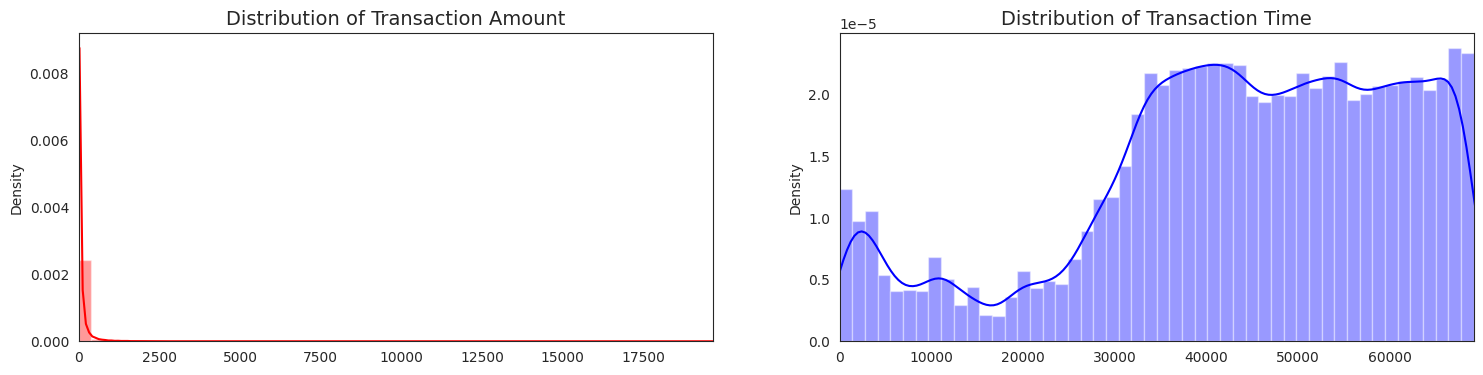

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [ ]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df_1 = pd.DataFrame(tmp)
df_1.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df_1.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


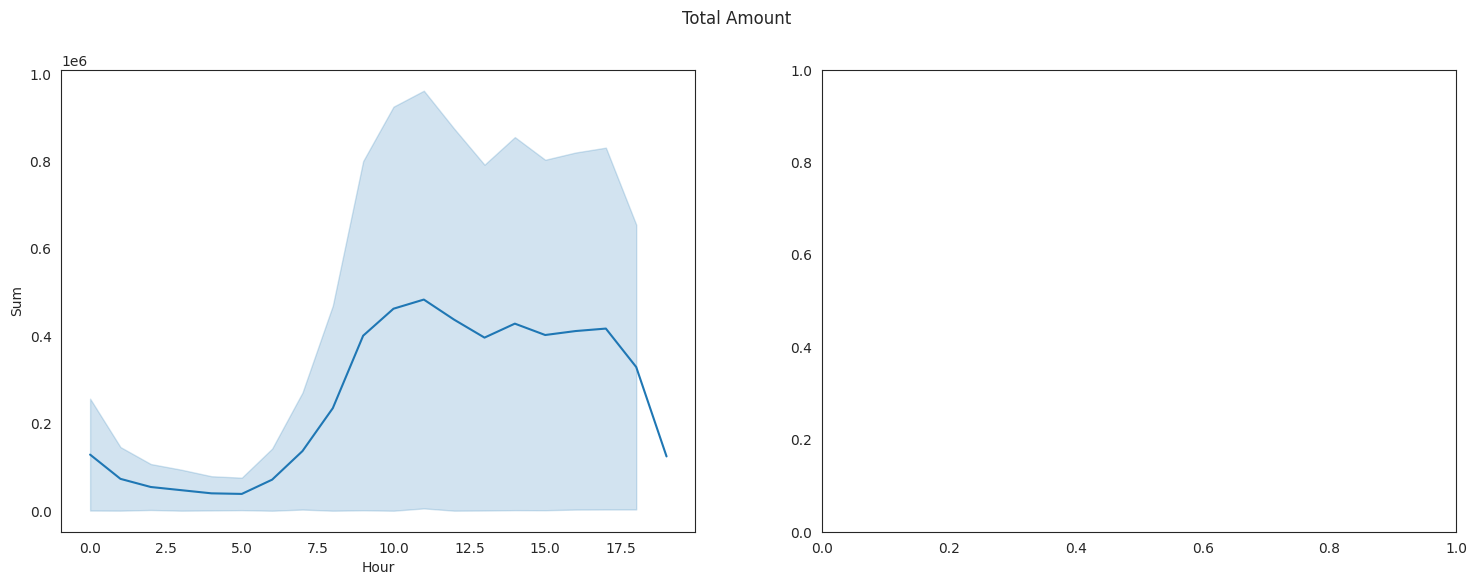

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df_1.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df_1.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

- Transactions amount

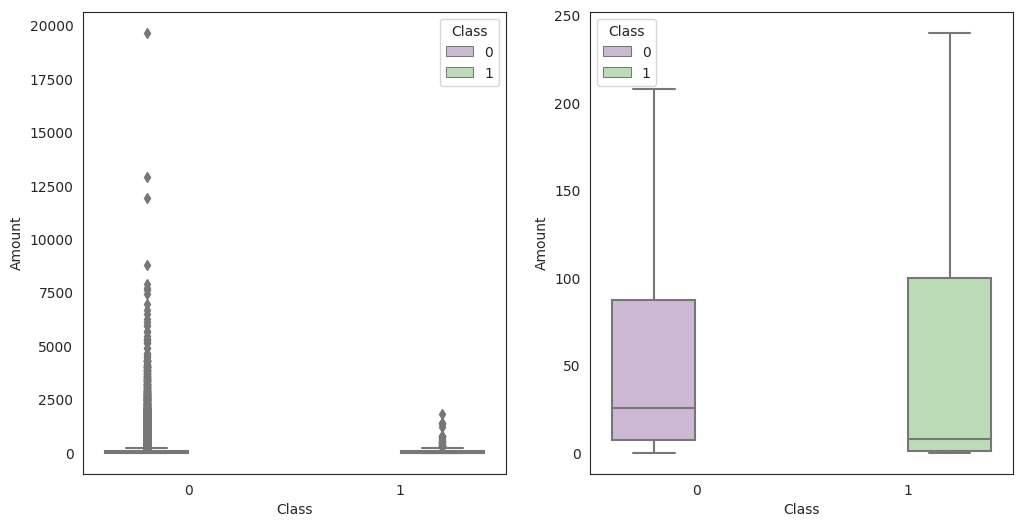

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

In [ ]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

- 분포가 고르지 않기 때문에 Time, Amount에 대해 Scale

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler 가 이상치에 덜 민감함

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Hour
0,1.542344,-1.922451,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.0
1,-0.284178,-1.922451,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.0
2,4.389595,-1.922409,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.0
3,1.217640,-1.922409,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.0
4,0.552444,-1.922366,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.0


In [ ]:
df.describe()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Hour
count,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,...,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000,104612.000000
mean,0.883808,-0.076656,-0.258080,-0.030069,0.683518,0.156778,-0.283356,0.099014,-0.117306,0.057159,...,-0.029672,-0.105525,-0.037286,0.009700,0.133780,0.026051,0.001496,0.001874,0.002218,11.616115
std,3.257450,0.740726,1.851193,1.648267,1.320165,1.345326,1.352092,1.301535,1.213145,1.236061,...,0.744769,0.639966,0.626354,0.595537,0.440080,0.492109,0.392952,0.321478,0.047041,4.842819
min,-0.317618,-1.922451,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,-0.228610,-0.484855,-1.024725,-0.598914,0.178055,-0.714778,-0.907253,-0.644176,-0.606869,-0.135356,...,-0.223737,-0.531169,-0.177239,-0.323270,-0.130279,-0.323599,-0.061551,-0.005136,0.000000,9.000000
50%,0.000000,0.000000,-0.260183,0.075634,0.758817,0.184812,-0.318398,-0.153050,-0.073217,0.076860,...,-0.056344,-0.081367,-0.049740,0.065721,0.172292,-0.069221,0.010494,0.023346,0.000000,12.000000
75%,0.771390,0.515145,1.154826,0.734920,1.385329,1.026339,0.245102,0.494394,0.409537,0.368189,...,0.121196,0.316058,0.080791,0.406938,0.421577,0.295791,0.084347,0.076758,0.000000,15.000000
max,244.037418,1.007033,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,1.000000,19.000000


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle= True)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.78 % of the dataset
Frauds 0.22 % of the dataset
Train: [     0      1      2 ... 104607 104608 104609] Test: [     7     12     14 ... 104606 104610 104611]
Train: [     0      1      2 ... 104609 104610 104611] Test: [     3     15     16 ... 104586 104599 104604]
Train: [     0      3      4 ... 104609 104610 104611] Test: [     1      2      5 ... 104601 104602 104607]
Train: [     1      2      3 ... 104609 104610 104611] Test: [     0      4      6 ... 104598 104605 104608]
Train: [     0      1      2 ... 104608 104610 104611] Test: [     9     11     17 ... 104590 104603 104609]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99777751 0.00222249]
[0.99780136 0.00219864]


In [ ]:
df = df.sample(frac=1)  #random sampling

# amount of fraud classes 492 rows. / under sampling
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Hour
81091,0.376045,0.567752,1.340816,-1.193502,0.390165,-1.405410,-1.458604,-0.422564,-0.995683,0.040060,...,-0.243469,-0.476723,0.127205,0.156383,0.128313,-0.340672,0.023856,0.015329,0,16.0
82818,-0.293004,0.600966,1.295270,0.272047,-0.162649,0.303256,0.255526,-0.079709,-0.040778,0.017952,...,-0.312568,-0.932532,-0.027676,-0.877933,0.341860,0.149363,-0.028448,0.008837,0,16.0
27758,0.069864,-0.452731,-1.290506,0.498108,1.991689,-1.647189,-0.045588,0.320136,-0.116020,-0.590287,...,0.949085,0.413273,-0.457191,-0.464129,0.711443,-0.480401,0.018416,0.096614,0,9.0
43061,0.106536,-0.170540,-15.020981,8.075240,-16.298091,5.664820,-11.918153,-4.246957,-14.716668,9.435084,...,2.525115,-0.832074,-0.186117,0.429781,0.697103,0.056031,-1.310888,-0.707403,1,11.0
22565,1.861081,-0.553602,-1.592451,0.178640,2.077045,1.701187,-0.698443,1.496743,0.006550,1.114777,...,0.258400,0.391755,0.122423,-0.350036,0.219123,0.035697,-0.075278,0.003419,0,8.0


- Correlation Matrices
 - Negative Correlations : V17,V14,V12 and V10
 - Postive Correlations : V2,V4,V11 and V19
 - using Boxplots

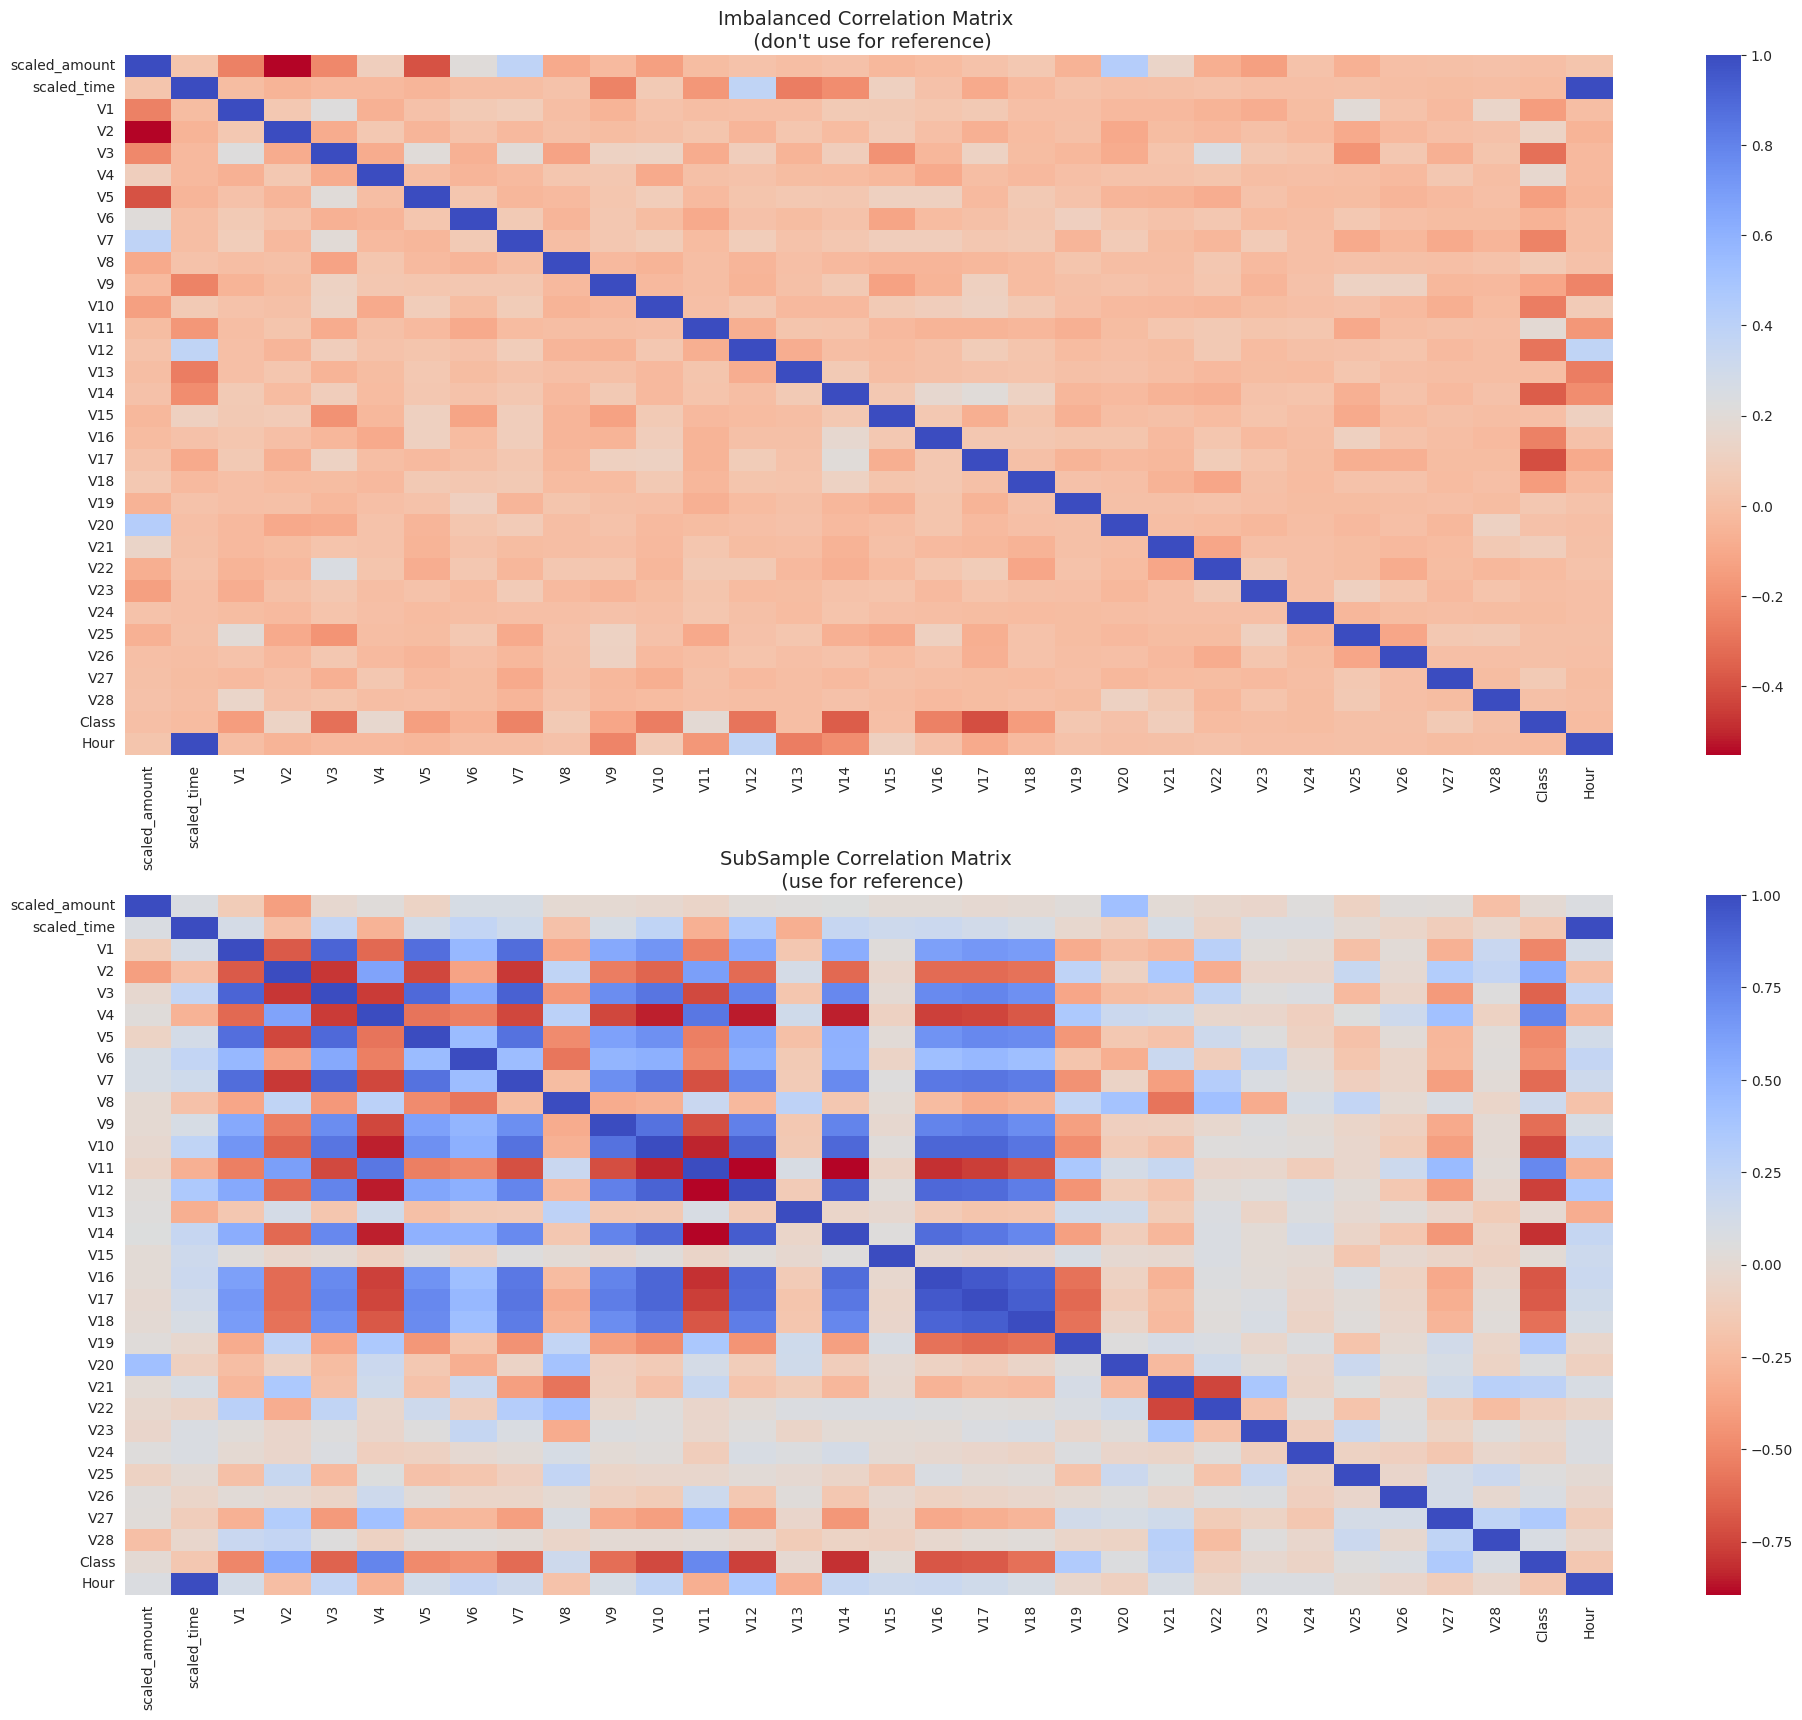

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

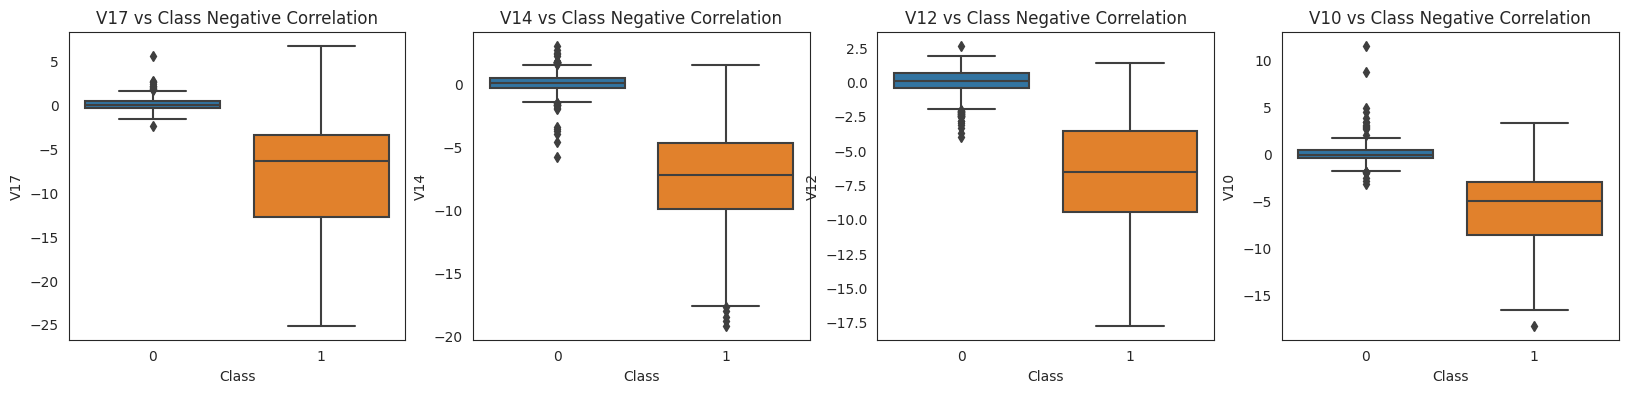

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df,ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df,ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df,ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df,ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

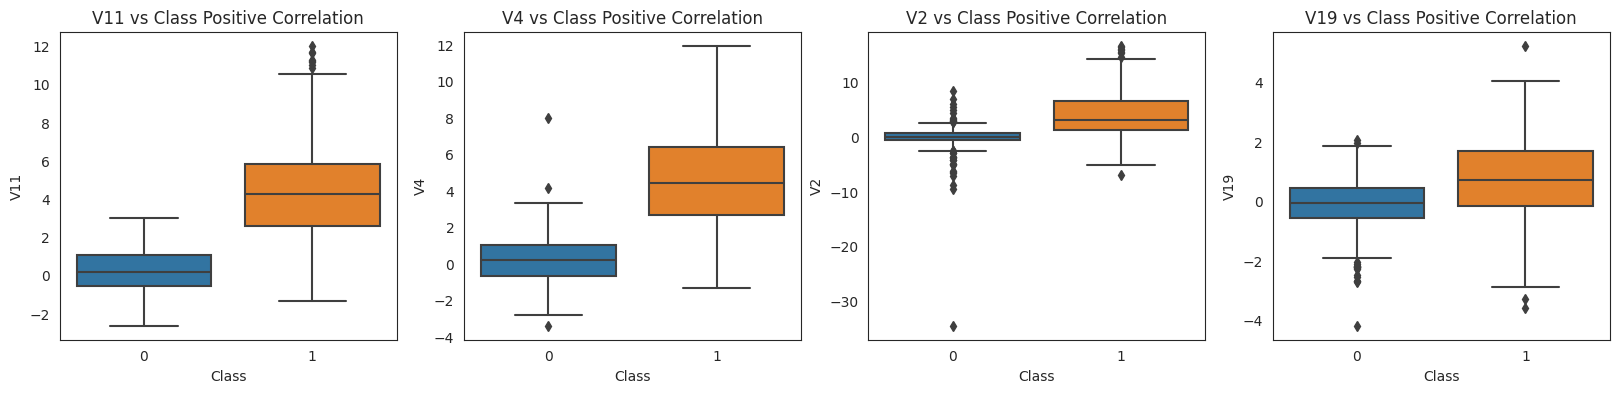

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))


sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [ ]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25


v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


type(new_df)

Quartile 25: -9.911056727 | Quartile 75: -4.7272001352499995
iqr: 5.183856591750001
Cut Off: 7.775784887625001
V14 Lower: -17.686841614625003
V14 Upper: 3.0485847523750014
Feature V14 Outliers for Fraud Cases: 5
V10 outliers:[-18.04999769, -19.21432549, -18.82208674, -18.49377336, -17.72163835]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.33979252375
V12 Upper: 4.762303010249998
V12 outliers: []
Feature V12 Outliers for Fraud Cases: 0
Number of Instances after outliers removal: 719
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -16.576943749999998
V10 Upper: 5.260368353999999
V10 outliers: [-18.27116817, -16.64962816]
Feature V10 Outliers for Fraud Cases: 2
Number of Instances after outliers removal: 71

pandas.core.frame.DataFrame

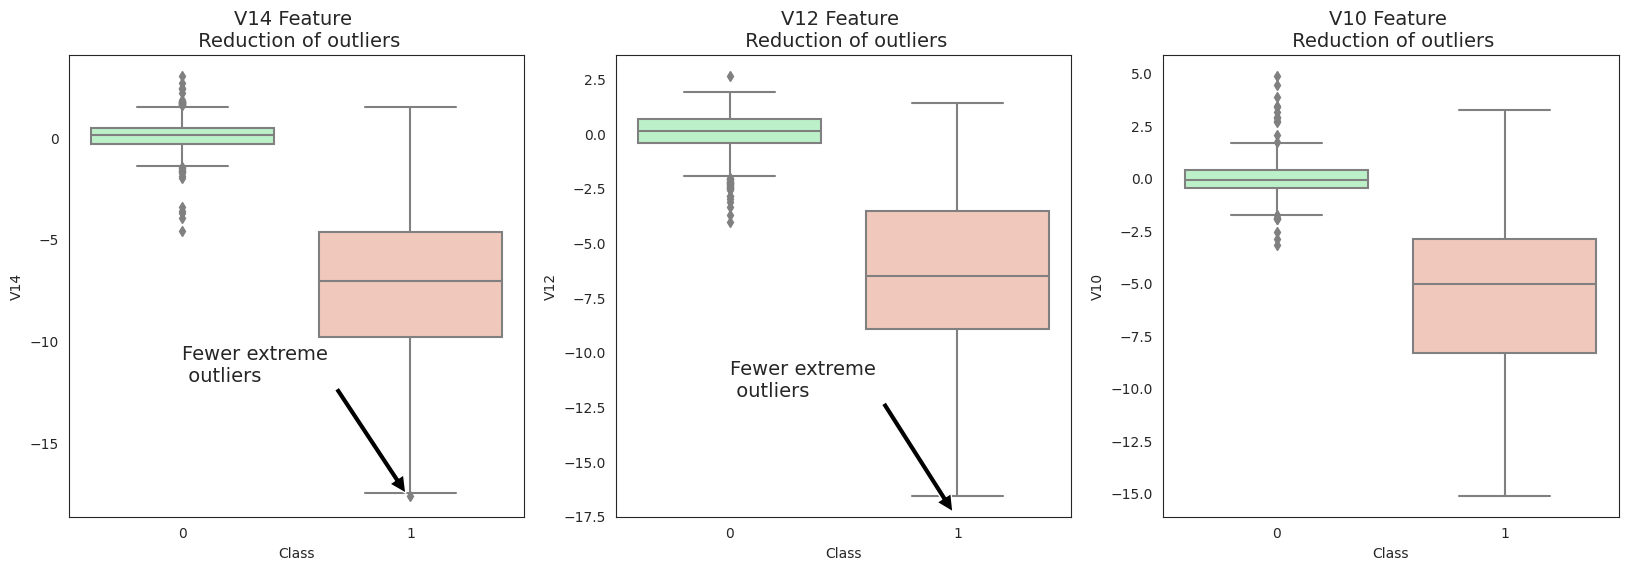

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

colors = ['#B3F9C5', '#f9c5b3','#C5B3F9']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
plt.show()

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [ ]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb
from xgboost import XGBClassifier    
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier # sklearn에 없음


classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "Ada Boost" : AdaBoostClassifier(),
    "Xgboost" : XGBClassifier(),
    'lightgbm' : LGBMClassifier(),
    'catboost' : CatBoostClassifier()
}


In [ ]:
print(classifiers.items())

dict_items([('LogisiticRegression', LogisticRegression()), ('KNearest', KNeighborsClassifier()), ('DecisionTreeClassifier', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Ada Boost', AdaBoostClassifier()), ('Xgboost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)), (

In [ ]:
from sklearn.model_selection import cross_val_score
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5:	learn: 0.6276568	total: 57.3ms	remaining: 9.5s
6:	learn: 0.6193513	total: 65.4ms	remaining: 9.28s
7:	learn: 0.6074719	total: 73.3ms	remaining: 9.09s
8:	learn: 0.5983094	total: 81.3ms	remaining: 8.95s
9:	learn: 0.5892797	total: 89.4ms	remaining: 8.85s
10:	learn: 0.5799880	total: 97ms	remaining: 8.72s
11:	learn: 0.5706795	total: 105ms	remaining: 8.64s
12:	learn: 0.5615570	total: 113ms	remaining: 8.58s
13:	learn: 0.5535054	total: 121ms	remaining: 8.52s
14:	learn: 0.5449836	total: 129ms	remaining: 8.47s
15:	learn: 0.5367892	total: 137ms	remaining: 8.42s
16:	learn: 0.5292374	total: 145ms	remaining: 8.39s
17:	learn: 0.5209055	total: 153ms	remaining: 8.34s
18:	learn: 0.5131445	total: 163ms	remaining: 8.39s
19:	learn: 0.5055680	total: 173ms	remaining: 8.46s
20:	learn: 0.4983066	total: 181ms	remaining: 8.45s
21:	learn: 0.4906146	total: 189ms	remaining: 8.4s
22:	learn: 0.4834769	total: 197ms	remaining: 8.35s
23:	learn: 0.4760817	total: 209ms	remaining: 8.48

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [ ]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.8%
Knears Neighbors Cross Validation Score 95.63%
Support Vector Classifier Cross Validation Score 95.8%
DecisionTree Classifier Cross Validation Score 94.93%


 - SMOTE(over-sampling)

<figure>
<img src = 'https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png'>
</figure>


- 장점:
  - synthetic example은 random하게 oversampling하는 것보다 overfitting 방지
  - 정보가 손실될 우려 감소
- 단점:
 - SMOTE는 minor class의 synthetic data를 생성하는 동안 인접해있는 major class의 instance들의 위치는 고려하지 않고, 클래스가 겹치거나 노이즈를 만들 수 있음
 - SMOTE는 고차원 데이터에 효율적이지 않을 수 있음.




In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique + Cross Validating 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE  during Cross Validation
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    
print('---' * 45)
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))

Length of X (train): 83690 | Length of y (train): 83690
Length of X (test): 20922 | Length of y (test): 20922
---------------------------------------------------------------------------------------------------------------------------------------
accuracy: 0.977560043015892
precision: 0.08252232325729145
recall: 0.897724039829303
f1: 0.15112107811175882


In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     20876
       Fraud       0.07      0.93      0.13        46

    accuracy                           0.97     20922
   macro avg       0.54      0.95      0.56     20922
weighted avg       1.00      0.97      0.98     20922



In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :3.397170066833496 sec


Test data with logstic regression

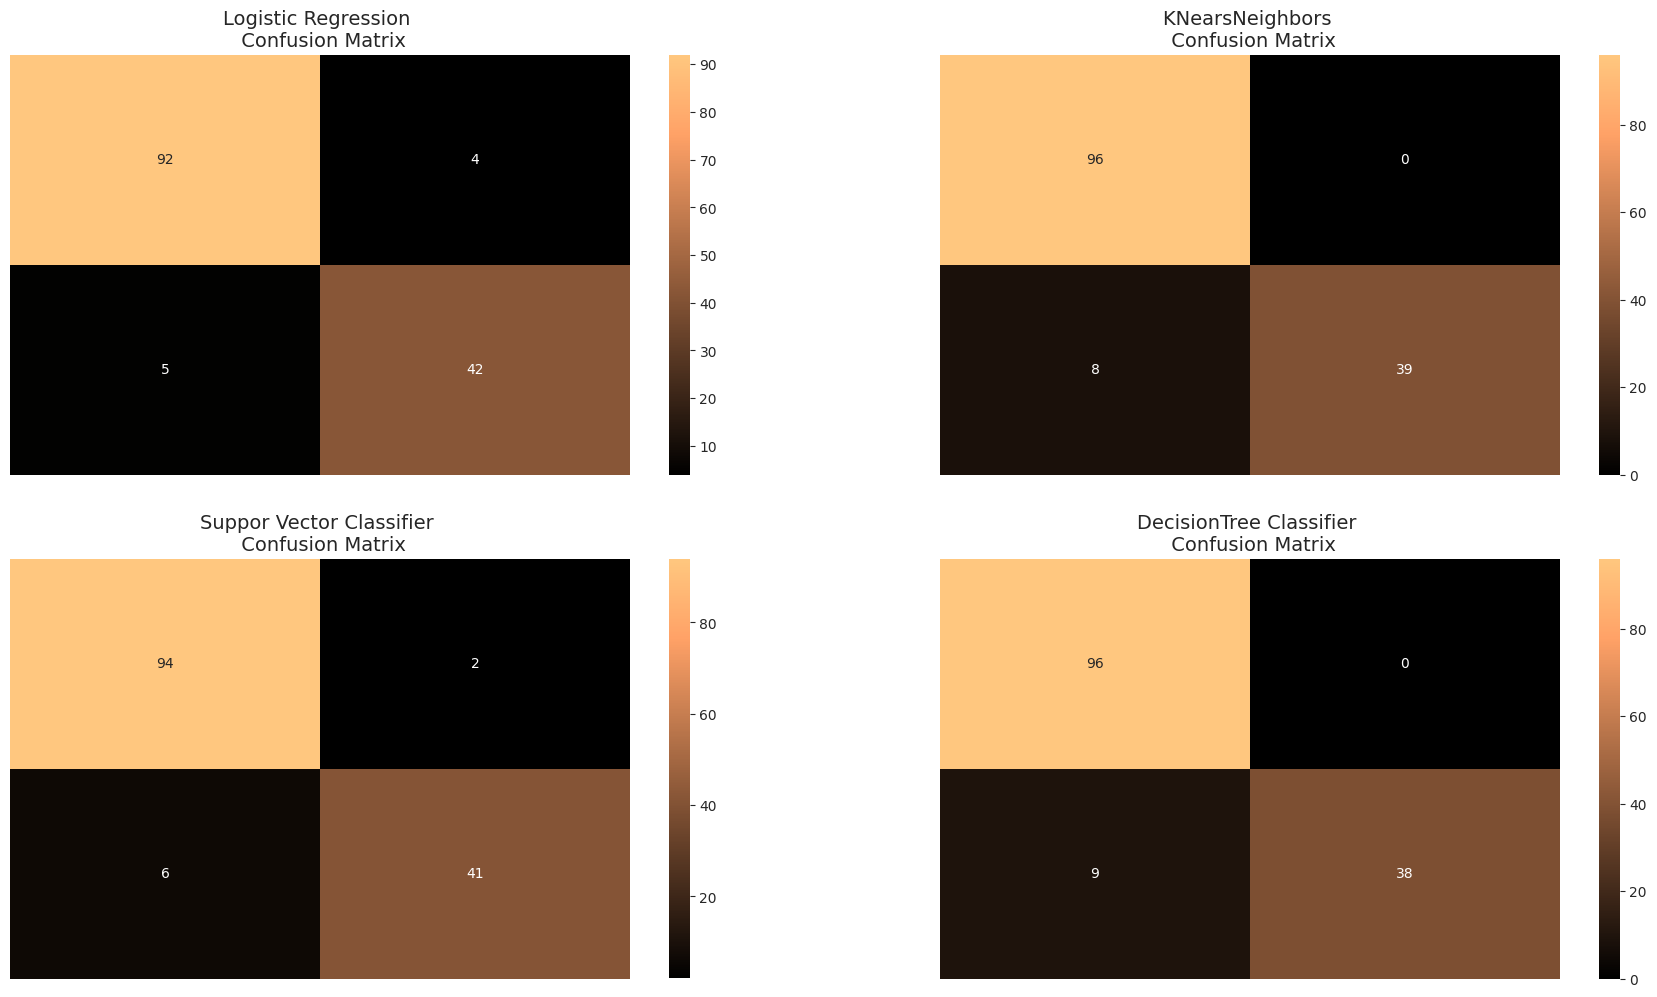

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        96
           1       0.91      0.89      0.90        47

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        96
           1       1.00      0.83      0.91        47

    accuracy                           0.94       143
   macro avg       0.96      0.91      0.93       143
weighted avg       0.95      0.94      0.94       143

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        96
           1       0.95      0.87      0.91        47

    accuracy                           0.94       143
   macro avg       0.95      0.93      0.94       143
weighted

In [ ]:
# new_df: 다운샘플링, class의 0과 1이 1:1로 구성

# 분류모형 만들고 파라메타 튜닝
from sklearn.neural_network import MLPClassifier
annModel = MLPClassifier().fit(new_df.drop("Class", axis=1), new_df.Class)
ann_pred = annModel.predict(df.drop("Class", axis=1).iloc[0:100, :])

print(classification_report(df.Class[0:100], ann_pred))
# df에 대해서 예측 100건을 해서 정분류율 계산.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00         1

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

